## REMO CMOR test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
#import cf_xarray as cfxr
import cftime as cfdt
import pandas as pd
#from datetime import datetime as dt
from datetime import timedelta as td
import datetime as dt
import pyremo as pr
import cordex as cx
import xclim as xc

import glob
import sys, os
import numpy as np
#from urllib.request import urlopen
import json
import cmor

#import iteration_utilities
#from pyhomogenize.time_control import time_control

could not find pyintorg, you need this for preprocessing. Please consider installing it from https://git.gerics.de/python/pyintorg.git


In [3]:
# example files
three_hours_inst_cordex = "/pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/ECMWF-ERAINT/evaluation/r1i1p1/GERICS-REMO2015/v1/3hr/tas/v20191030/tas_EUR-22_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_3hr_197901010100-197912312200.nc"
three_hours_mean_cordex = "/pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/ECMWF-ERAINT/evaluation/r1i1p1/GERICS-REMO2015/v1/3hr/pr/v20191030/pr_EUR-22_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_3hr_197901010130-197912312230.nc"
three_hours_inst_cmip6 = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/3hr/tas/gn/v20190710/tas_3hr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001010300-187001010000.nc"
three_hours_mean_cmip6 = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/3hr/pr/gn/v20190710/pr_3hr_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001010130-186912312230.nc"
six_hours_inst_cordex = "/pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/ECMWF-ERAINT/evaluation/r1i1p1/GERICS-REMO2015/v1/6hr/ta850/v20191030/ta850_EUR-22_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_6hr_1979010106-1979123118.nc"
one_hour_mean_cordex = "/pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/ECMWF-ERAINT/evaluation/r1i1p1/GERICS-REMO2015/v1/1hr/pr/v20191030/pr_EUR-22_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_1hr_197901010100-198001010000.nc"

sem_inst_cordex = "/pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/ECMWF-ERAINT/evaluation/r1i1p1/GERICS-REMO2015/v1/sem/tas/v20191030/tas_EUR-22_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_sem_197903-198011.nc"
sem_mean_cordex = "/pool/data/CORDEX/data/cordex/output/EUR-22/GERICS/ECMWF-ERAINT/evaluation/r1i1p1/GERICS-REMO2015/v1/sem/pr/v20191030/pr_EUR-22_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_sem_197903-198011.nc"

mon_mean_cmip6 = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gn/v20190710/pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912.nc"
mon_inst_cmip6 = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gn/v20190710/tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912.nc"

In [50]:
ds = xr.open_dataset(sem_mean_cordex, use_cftime=True)
ds

<xarray.Dataset>
Dimensions:                     (time: 7, bnds: 2, rlat: 201, rlon: 225, vertices: 4)
Coordinates:
  * time                        (time) object 1979-04-16 00:00:00 ... 1980-10...
  * rlat                        (rlat) float64 -22.88 -22.66 ... 20.9 21.12
  * rlon                        (rlon) float64 -29.86 -29.64 ... 19.2 19.42
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) object ...
    rotated_latitude_longitude  int32 ...
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    pr                          (time, rlat, rlon) float32 ...
Attributes: (12/34)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  evaluation
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/91c930c2-95b7-4876-9afa-2780...

In [4]:
from dask.distributed import Client
client = Client()
client

/work/ch0636/g300046/conda_envs/cmor/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33670 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300046/advanced//proxy/33670/status,
Dashboard: /user/g300046/advanced//proxy/33670/status,Workers: 6
Total threads: 24,Total memory: 31.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43064,Workers: 6
Dashboard: /user/g300046/advanced//proxy/33670/status,Total threads: 24
Started: Just now,Total memory: 31.25 GiB
Comm: tcp://127.0.0.1:38503,Total threads: 4
Dashboard: /user/g300046/advanced//proxy/40323/status,Memory: 5.21 GiB
Nanny: tcp://127.0.0.1:34125,


In [5]:
pr.cmor.derivator.get_params('hurs')

['DEW2', 'TEMP2']

### Define relevant functions

In [6]:
def open_mfdataset(files,
                   use_cftime=True,
                   parallel=True,
                   data_vars='minimal',
                   chunks={'time':1}, 
                   coords='minimal',
                   compat='override',
                   drop=None,
                   preprocess=None,
                   **kwargs):
    """optimized function for opening large cf datasets.

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115
    
    """
    def drop_all_coords(ds):
        if preprocess is not None:
            ds = preprocess(ds, use_cftime=use_cftime)
        return ds.reset_coords(drop=True)
    
    ds = xr.open_mfdataset(files,
                           parallel=parallel,
                           decode_times=False,
                           combine='by_coords',
                           preprocess=drop_all_coords,
                           decode_cf=False,
                           chunks=chunks,
                           data_vars=data_vars,
                           coords='minimal',
                           compat='override',
                           **kwargs)
    return xr.decode_cf(ds, use_cftime=use_cftime)


def correct_monthly_time_axis(ds):

    def _begin_of(date, precision='day'):
        while True:
            m  = getattr(date, precision)
            pm = getattr((date - td(hours=1)), precision)
            if pm !=m:
                return date
            date -= td(hours=1)
        
    def _end_of(date, precision='day'):
        while True:
            m  = getattr(date, precision)
            nm = getattr((date + td(hours=1)), precision)
            if nm != m:
                return date
            date += td(hours=1)
            
    def check_int(int):
        if int == 0:
            return 1
        return int
        
    def _year(str):
        return check_int(int(str[:4]))
    
    def _month(str):
        return check_int(int(str[4:6]))
    
    def _day(str):
        return check_int(int(str[6:8]))
    
    def numpy_to_date(da):
        numpyfloat = str(da.values)
        year  = _year(numpyfloat)
        month = _month(numpyfloat)
        day   = _day(numpyfloat)
        return cftime.datetime(year, month, day, calendar=da.calendar)
    
    time = [numpy_to_date(t) for t in ds.time]
    start = _begin_of(time[0], 'month')
    end   = _end_of(time[-1], 'month')
    t1    = xr.cftime_range(start, end, freq='MS')
    t2    = xr.cftime_range(start, end, freq='M')
    refdate = cftime.datetime(1850, 1, 1, calendar = ds.time.calendar)
    dates = t1 + (t2 - t1 + td(days=1)) / 2
    return (dates-refdate)/ np.timedelta64(1, 'D')
    
def select_domain(ds, domain):
    domain = cx.cordex_domain(domain)
    # the method=='nearest' approach does not work well with dask
    return ds.sel(rlon=slice(domain.rlon.min(), domain.rlon.max()), rlat=slice(domain.rlat.min(), domain.rlat.max()))


def add_bnds(ds, bnds):
    if isinstance(bnds, str): bnds = [bnds]
    ds_bnds = ds.cf.add_bounds(bnds)
    for bnd in bnds:
        ds_bnds = ds_bnds.rename({bnd+'_bounds':bnd+'_bnds'})
    ds_bnds = ds_bnds.rename_dims({'bounds' : 'bnds'})
    return ds_bnds


def get_bnds(values):
    bnds = [None]*(len(values) + 1)
    bnds[0] = values[0] - (values[1] - values[0]) / 2
    bnds[len(values)] = values[-1] + (values[-1] - values[-2]) / 2
    i = 1
    while i < len(values):
        bnds[i] = values[i] - (values[i] - values[i-1]) / 2
        i += 1
    return bnds  

def create_dataset(old_ds, var=None, table=pd.DataFrame()):
    if not var or table.empty: return ds
    new_ds = xr.Dataset(data_vars = {var : ds[var_table.variable.values[0]],
                                     'rotated_latitude_longitude' : ds.rotated_latitude_longitude}, 
                        attrs = ds.attrs)
    new_ds[var] = xc.units.convert_units_to(new_ds[var], var_table.units.values[0])
    new_ds[var].attrs["units"] = var_table.units.values[0]
    return new_ds

### Read REMO raw output data

In [11]:
pattern = '/work/ch0636/g300046/remo_results_056000/*/e056000m*.nc'
#pattern = '/work/ch0636/g300046/remo_results_056000/1979/hourly/e056000e_c167*.nc'
filenames = glob.glob(pattern)
filenames.sort()
filenames

['/work/ch0636/g300046/remo_results_056000/1979/e056000m197901.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197902.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197903.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197904.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197905.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197906.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197907.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197908.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197909.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197910.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197911.nc',
 '/work/ch0636/g300046/remo_results_056000/1979/e056000m197912.nc',
 '/work/ch0636/g300046/remo_results_056000/1980/e056000m198001.nc',
 '/work/ch0636/g300046/remo_results_056000/1980/e056000m198002.nc',
 '/work/ch0636/g300046/remo_results_056000/1980/

In [8]:
pr.codes.get_dict('prc')

{'variable': 'APRC',
 'description': 'convective precipitation',
 'units': 'mm',
 'layer': 1.0,
 'time_cell_method': None,
 'cf_name': 'prc',
 'code': 143}

In [12]:
ds = open_mfdataset(filenames, chunks={}, parallel=True, preprocess=pr.preprocess)
ds

<xarray.Dataset>
Dimensions:                     (rlon: 433, rlat: 433, meansea: 1, height10m: 1, height2m: 1, lev_4: 1, nhyi: 28, nhym: 27, lev_5: 1, snlevs: 3, time: 456)
Coordinates:
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
  * meansea                     (meansea) float64 0.0
  * height10m                   (height10m) float64 10.0
  * height2m                    (height2m) float64 2.0
  * lev_4                       (lev_4) float64 1.0
  * lev_5                       (lev_5) float64 27.0
  * snlevs                      (snlevs) float64 1.0 2.0 3.0
    lon                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time                        (time) object 1979-01-15 00:00:00 ... 2016-12...
Dimensions without coordinates: nhyi, nhym
Data variables: (12/129)
    hyai                        (nhyi) float64 dask.array<chunksize=(28,), meta=np.ndarray>
    hybi                        (nhyi) float64 dask.array<chunksize=(28,), meta=np.ndarray>
    hyam                        (nhym) float64 dask.array<chunksize=(27,), meta=np.ndarray>
    hybm                        (nhym) float64 dask.array<chunksize=(27,), meta=np.ndarray>
    rotated_latitude_longitude  |S1 ...
    QDB                         (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    ...                          ...
    ALSOFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    USTRFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    VSTRFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    EVAPFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    TMCHFL                      (time, rlat, rlon) float32 dask.array<chunksize=(1, 433, 433), meta=np.ndarray>
    SNMLRHO                     (time, snlevs, rlat, rlon) float32 dask.array<chunksize=(1, 3, 433, 433), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
    Conventions:          CF-1.6
    history:              preprocessing with pyremo = 0.1.0
    institution:          European Centre for Medium-Range Weather Forecasts
    CDO:                  Climate Data Operators version 1.9.6 (http://mpimet...
    _NCProperties:        version=2,netcdf=4.7.4,hdf5=1.10.6
    forcing_file_format:  NetCDF
    remo_version:         2.0.0
    git_branch:           nc_meta
    git_hash:             c4ee7f4
    system:               Linux eddy3 2.6.32-754.33.1.el6.x86_64 #1 SMP Mon A...

In [13]:
ds.APRC

<xarray.DataArray 'APRC' (time: 456, rlat: 433, rlon: 433)>
dask.array<concatenate, shape=(456, 433, 433), dtype=float32, chunksize=(1, 433, 433), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -28.93 -28.82 -28.71 -28.6 ... 18.37 18.49 18.6
  * rlat     (rlat) float64 -23.93 -23.82 -23.71 -23.6 ... 23.37 23.49 23.6
    lon      (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time     (time) object 1979-01-15 00:00:00 ... 2016-12-15 00:00:00
Attributes:
    long_name:     convective  precipitation
    units:         mm
    code:          143
    leveltype:     1
    grid_mapping:  rotated_latitude_longitude
    variable:      APRC
    description:   convective precipitation
    layer:         1.0
    cf_name:       prc

In [48]:
pr.cmor.derivator.derive(ds, 'evspsbl')

/mnt/lustre01/pf/zmaw/g300046/python/packages/pyremo/pyremo/cmor/derived.py:44: UserWarning: computing evspsbl from ['EVAP']
  warn("computing {} from {}".format(cf_varname, [p for p in params]))


<xarray.DataArray 'evspsbl' (time: 12, rlat: 433, rlon: 433)>
dask.array<mul, shape=(12, 433, 433), dtype=float32, chunksize=(1, 433, 433), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -28.93 -28.82 -28.71 -28.6 ... 18.37 18.49 18.6
  * rlat     (rlat) float64 -23.93 -23.82 -23.71 -23.6 ... 23.37 23.49 23.6
    lon      (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time     (time) object 1979-01-15 00:00:00 ... 1979-12-15 00:00:00
Attributes:
    long_name:     surface evaporation
    units:         mm
    code:          182
    leveltype:     1
    grid_mapping:  rotated_latitude_longitude
    variable:      EVAP
    description:   surface evaporation
    layer:         1.0
    cf_name:       evspsbl

In [19]:
xr.infer_freq(ds.time)

In [15]:
ds_tas = pr.cmor.prepare_variable(ds, 'prc',
                                  CORDEX_domain='EUR-11')
ds_tas

<xarray.Dataset>
Dimensions:                     (rlon: 424, rlat: 412, time: 456)
Coordinates:
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.15
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.83
    lon                         (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lat                         (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
  * time                        (time) object 1979-01-15 00:00:00 ... 2016-12...
Data variables:
    prc                         (time, rlat, rlon) float32 dask.array<chunksize=(1, 412, 424), meta=np.ndarray>
    rotated_latitude_longitude  |S1 ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
    Conventions:          CF-1.6
    history:              preprocessing with pyremo = 0.1.0
    institution:          European Centre for Medium-Range Weather Forecasts
    CDO:                  Climate Data Operators version 1.9.6 (http://mpimet...
    _NCProperties:        version=2,netcdf=4.7.4,hdf5=1.10.6
    forcing_file_format:  NetCDF
    remo_version:         2.0.0
    git_branch:           nc_meta
    git_hash:             c4ee7f4
    system:               Linux eddy3 2.6.32-754.33.1.el6.x86_64 #1 SMP Mon A...

In [51]:
#pr.cmor.utils._get_time_cell_method('orog', 'fx')
pr.cmor.utils._get_cfvarinfo('orog', 'fx')

{'frequency': 'fx',
 'modeling_realm': 'land',
 'standard_name': 'surface_altitude',
 'units': 'm',
 'cell_methods': 'area: mean',
 'cell_measures': 'area: areacella',
 'long_name': 'Surface Altitude',
 'comment': "The surface called 'surface' means the lower boundary of the atmosphere. Altitude is the (geometric) height above the geoid, which is the reference geopotential surface. The geoid is similar to mean sea level.",
 'dimensions': 'longitude latitude',
 'out_name': 'orog',
 'type': 'real',
 'positive': '',
 'valid_min': '',
 'valid_max': '',
 'ok_min_mean_abs': '',
 'ok_max_mean_abs': ''}

In [23]:
sem = xr.open_dataset("/pool/data/CORDEX/data/cordex/output/EUR-11/GERICS/ECMWF-ERAINT/evaluation/r1i1p1/GERICS-REMO2015/v1/sem/tas/v20180813/tas_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_sem_198012-199011.nc")
sem

<xarray.Dataset>
Dimensions:                     (time: 40, bnds: 2, rlat: 412, rlon: 424, vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 1981-01-15 ... 1990-10-...
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.84
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.16
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] ...
    rotated_latitude_longitude  int32 ...
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    tas                         (time, rlat, rlon) float32 ...
Attributes: (12/29)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  evaluation
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    contact:                        gerics-cordex@hzg.de
    ...                             ...
    project_id:                     CORDEX
    table_id:                       Table sem (March 2015) 128671537a87814f76...
    title:                          GERICS-REMO2015 model output prepared for...
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1

In [72]:
ds

<xarray.Dataset>
Dimensions:                     (rlon: 433, rlat: 433, height2m: 1, time: 2160)
Coordinates:
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
  * height2m                    (height2m) float64 2.0
    lon                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time                        (time) object 1979-01-01 01:00:00 ... 1979-04...
Data variables:
    rotated_latitude_longitude  |S1 ...
    TEMP2                       (time, height2m, rlat, rlon) float32 dask.array<chunksize=(744, 1, 433, 433), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
    Conventions:          CF-1.6
    history:              preprocessing with pyremo = 0.1.0
    institution:          European Centre for Medium-Range Weather Forecasts
    CDO:                  Climate Data Operators version 1.9.6 (http://mpimet...
    _NCProperties:        version=2,netcdf=4.7.4,hdf5=1.10.6
    forcing_file_format:  NetCDF
    remo_version:         2.0.0
    git_branch:           nc_meta
    git_hash:             c4ee7f4
    system:               Linux eddy3 2.6.32-754.33.1.el6.x86_64 #1 SMP Mon A...

### resample to `3hr`

In [103]:
xr.open_dataset(three_hours_inst_cmip6)

<xarray.Dataset>
Dimensions:   (time: 58440, lat: 96, bnds: 2, lon: 192)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-01T03:00:00 ... 1870-01-01
  * lat       (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height    float64 ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 ...
    lon_bnds  (lon, bnds) float64 ...
    tas       (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/18b952dc-119d-4542-9bdd-16302cedcfd6

In [102]:
drv.derivator.derive(ds, 'huss')

<xarray.DataArray 'huss' (time: 12, height2m: 1, rlat: 433, rlon: 433)>
dask.array<truediv, shape=(12, 1, 433, 433), dtype=float32, chunksize=(1, 1, 433, 433), chunktype=numpy.ndarray>
Coordinates:
  * rlon      (rlon) float64 -28.93 -28.82 -28.71 -28.6 ... 18.37 18.49 18.6
  * rlat      (rlat) float64 -23.93 -23.82 -23.71 -23.6 ... 23.37 23.49 23.6
  * height2m  (height2m) float64 2.0
    lon       (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat       (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time      (time) object 1979-01-15 00:00:00 ... 1979-12-15 00:00:00
Attributes:
    long_name:     2m dew point temperature
    units:         kg/kg
    code:          168
    leveltype:     105
    grid_mapping:  rotated_latitude_longitude
    variable:      DEW2
    description:   2m dew point temperature
    layer:         1.0

In [108]:
import pyremo as pr

In [30]:
ds.PS

<xarray.DataArray 'PS' (time: 456, rlat: 433, rlon: 433)>
dask.array<concatenate, shape=(456, 433, 433), dtype=float32, chunksize=(1, 433, 433), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -28.93 -28.82 -28.71 -28.6 ... 18.37 18.49 18.6
  * rlat     (rlat) float64 -23.93 -23.82 -23.71 -23.6 ... 23.37 23.49 23.6
    lon      (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time     (time) object 1979-01-15 00:00:00 ... 2016-12-15 00:00:00
Attributes:
    long_name:     Surface pressure
    units:         Pa
    code:          134
    leveltype:     1
    grid_mapping:  rotated_latitude_longitude
    variable:      PS
    description:   Surface pressure
    layer:         1.0
    cf_name:       ps

In [29]:
filename = pr.cmor.cmorize_variable(ds, 'tas', 'Amon', cx.cordex_cmor_table('remo_example'), 
                                  CORDEX_domain='EUR-11', allow_units_convert=True, allow_derive=True)


C Traceback:
In function: cmor_grid
! 

!!!!!!!!!!!!!!!!!!!!!!!!!
!
! Warning: it is recommended you pass the latitude bounds values when defining a grid
!
!!!!!!!!!!!!!!!!!!!!!!!!!


C Traceback:
In function: cmor_grid
! 

!!!!!!!!!!!!!!!!!!!!!!!!!
!
! Warning: it is recommended you pass the longitude bounds values when defining a grid
!
!!!!!!!!!!!!!!!!!!!!!!!!!


C Traceback:
In function: cmor_close_variable
! 

!!!!!!!!!!!!!!!!!!!!!!!!!
!
! Warning: while closing variable 2 (tas, table Amon)
! we noticed you wrote 0 time steps for the variable,
! but its time axis 0 (time) has 456 time steps
!
!!!!!!!!!!!!!!!!!!!!!!!!!



In [25]:
cmor_ds = xr.open_dataset(filename)
cmor_ds

<xarray.Dataset>
Dimensions:                     (time: 456, bnds: 2, rlat: 412, rlon: 424)
Coordinates:
  * time                        (time) datetime64[ns] 1979-01-14T12:00:00 ......
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.72 21.83
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.15
    lat                         (rlat, rlon) float64 ...
    lon                         (rlat, rlon) float64 ...
    height                      float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] ...
    rlat_bnds                   (rlat, bnds) float64 ...
    rlon_bnds                   (rlon, bnds) float64 ...
    rotated_latitude_longitude  int32 ...
    tas                         (time, rlat, rlon) float32 ...
Attributes: (12/53)
    CORDEX_domain:           EUR-11
    Conventions:             CF-1.7 CORDEX-CMIP-6.2
    activity_id:             CORDEX
    branch_method:           standard
    branch_time_in_child:    59400.0
    branch_time_in_parent:   59400.0
    ...                      ...
    title:                   REMO2-0-0 output prepared for CORDEX-CMIP6
    tracking_id:             hdl:21.14100/27dc4ae0-b642-456c-ab56-0e811e92731c
    variable_id:             tas
    variant_label:           r1i1p1f1
    license:                 CMIP6 model data produced by Lawrence Livermore ...
    cmor_version:            3.6.1

In [27]:
cmor_ds.nbytes / 1.e6

321.45694

In [121]:
ds = xr.open_dataset(three_hours_mean_cmip6)
ds

<xarray.Dataset>
Dimensions:    (time: 58440, bnds: 2, lat: 96, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T01:30:00 ... 1869-12-31T22:30:00
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            pr
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/75b1f785-b942-4436-854f-19b74540ab9a

In [84]:
xr.infer_freq(ds.time)

'3H'

In [69]:
surflib = pr.data.surflib('EUR-11')

In [70]:
surflib

<xarray.Dataset>
Dimensions:       (rlon: 433, rlat: 433)
Coordinates:
  * rlon          (rlon) float64 -28.93 -28.82 -28.71 ... 18.38 18.48 18.59
  * rlat          (rlat) float64 -23.93 -23.82 -23.71 ... 23.38 23.48 23.59
Data variables: (12/14)
    rotated_pole  int32 ...
    FIB           (rlat, rlon) float32 ...
    BLA           (rlat, rlon) float32 ...
    AZ0           (rlat, rlon) float32 ...
    ALB           (rlat, rlon) float32 ...
    VGRAT         (rlat, rlon) float32 ...
    ...            ...
    FOREST        (rlat, rlon) float32 ...
    FAO           (rlat, rlon) float32 ...
    WSMX          (rlat, rlon) float32 ...
    BETA          (rlat, rlon) float32 ...
    WMINLOK       (rlat, rlon) float32 ...
    WMAXLOK       (rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 01 12:03:07 2020: cdo -f nc copy lib_EUR-11_frac li...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [71]:
surflib.assign_coords({'lon': ds.lon, 'lat': ds.lat})

<xarray.Dataset>
Dimensions:       (rlon: 433, rlat: 433)
Coordinates:
  * rlon          (rlon) float64 -28.93 -28.82 -28.71 ... 18.38 18.48 18.59
  * rlat          (rlat) float64 -23.93 -23.82 -23.71 ... 23.38 23.48 23.59
    lat           (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
Data variables: (12/14)
    rotated_pole  int32 1
    FIB           (rlat, rlon) float32 ...
    BLA           (rlat, rlon) float32 ...
    AZ0           (rlat, rlon) float32 ...
    ALB           (rlat, rlon) float32 ...
    VGRAT         (rlat, rlon) float32 ...
    ...            ...
    FOREST        (rlat, rlon) float32 ...
    FAO           (rlat, rlon) float32 ...
    WSMX          (rlat, rlon) float32 ...
    BETA          (rlat, rlon) float32 ...
    WMINLOK       (rlat, rlon) float32 ...
    WMAXLOK       (rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 01 12:03:07 2020: cdo -f nc copy lib_EUR-11_frac li...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [72]:
surflib

<xarray.Dataset>
Dimensions:       (rlon: 433, rlat: 433)
Coordinates:
  * rlon          (rlon) float64 -28.93 -28.82 -28.71 ... 18.38 18.48 18.59
  * rlat          (rlat) float64 -23.93 -23.82 -23.71 ... 23.38 23.48 23.59
Data variables: (12/14)
    rotated_pole  int32 1
    FIB           (rlat, rlon) float32 ...
    BLA           (rlat, rlon) float32 ...
    AZ0           (rlat, rlon) float32 ...
    ALB           (rlat, rlon) float32 ...
    VGRAT         (rlat, rlon) float32 ...
    ...            ...
    FOREST        (rlat, rlon) float32 ...
    FAO           (rlat, rlon) float32 ...
    WSMX          (rlat, rlon) float32 ...
    BETA          (rlat, rlon) float32 ...
    WMINLOK       (rlat, rlon) float32 ...
    WMAXLOK       (rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 01 12:03:07 2020: cdo -f nc copy lib_EUR-11_frac li...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [75]:
filename = pr.cmor.cmorize_variable(surflib.assign_coords({'lon': ds.lon, 'lat': ds.lat}), 'orog', 'fx', cx.cordex_cmor_table('remo_example'), 
                                  CORDEX_domain='EUR-11', time_units=None, allow_units_convert=True)


C Traceback:
In function: cmor_grid
! 

!!!!!!!!!!!!!!!!!!!!!!!!!
!
! Warning: it is recommended you pass the latitude bounds values when defining a grid
!
!!!!!!!!!!!!!!!!!!!!!!!!!


C Traceback:
In function: cmor_grid
! 

!!!!!!!!!!!!!!!!!!!!!!!!!
!
! Warning: it is recommended you pass the longitude bounds values when defining a grid
!
!!!!!!!!!!!!!!!!!!!!!!!!!



In [76]:
filename

'CORDEX/CORDEX-CMIP6/CORDEX/GERICS/REMO2-0-0/ECMWF/ECMWF-IFS-LR/historical/r1i1p1f1/fx/orog/gn/v20211112/orog_fx_REMO2-0-0_ECMWF-IFS-LR_historical_r1i1p1f1_gn.nc'

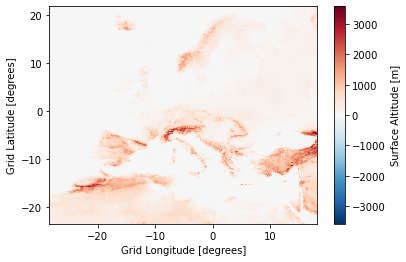

In [78]:
xr.open_dataset(filename).orog.plot()